<div style="text-align: center;">
  <div style="display: inline-block; min-width: 60%; font-weight: bold; font-size: 24px; color: white; background-color: red; padding: 15px 20px; border: 2px solid white; border-radius: 8px;">
    Mistral OCR for Documents Parsing
  </div>
</div>


# **1. Install Libraries**

In [3]:
%%capture
! pip install mistralai
! pip install markdown2
! pip install pdf2image
! apt-get update && apt-get install -y poppler-utils
! pip install tabulate

# **2. Import Libraries**

In [4]:
import os
import base64
import logging
import time
from pathlib import Path
import pandas as pd
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from PIL import Image
import re

from IPython.display import display, HTML
import base64
import markdown
import markdown2

import io
from io import BytesIO, StringIO

import warnings
import sys
import contextlib

from mistralai import Mistral

api_key = "******************************"

# **3. Inference**

In [5]:
def clean_markdown_table(md_table):
    """Clean and flatten markdown table headers and remove HTML/LaTeX."""
    md_table = re.sub(r'<br\s*/?>', ' ', md_table, flags=re.IGNORECASE)
    md_table = re.sub(r'\$+', '', md_table)
    
    lines = md_table.strip().split('\n')
    if len(lines) < 3:
        return None

    header_1 = lines[0].strip().strip('|').split('|')
    header_2 = lines[2].strip().strip('|').split('|') if lines[1].strip().startswith('|') else []

    # Merge multi-row headers if possible
    if header_2 and len(header_1) == len(header_2):
        headers = [f"{h1.strip()} {h2.strip()}".strip() for h1, h2 in zip(header_1, header_2)]
        data_start = 3
    else:
        headers = [h.strip() for h in header_1]
        data_start = 2

    # Extract the data rows
    data_rows = []
    for line in lines[data_start:]:
        if "|" not in line:
            continue
        row = [cell.strip() for cell in line.strip().strip('|').split('|')]
        if len(row) == len(headers):
            data_rows.append(row)

    if not data_rows:
        return None

    df = pd.DataFrame(data_rows, columns=headers)
    return df

def display_text_with_pdf_or_image_plain(raw_text, file_path, pdf_page=0, max_width=800):
    """
    Display image or PDF and extract markdown tables with complex headers,
    displaying them as clean Pandas DataFrames.
    """
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    # --- Display image or PDF ---
    try:
        if file_path.lower().endswith(".pdf"):
            images = convert_from_path(file_path, first_page=pdf_page + 1, last_page=pdf_page + 1)
            img = images[0].convert("RGB")
        else:
            img = Image.open(file_path).convert("RGB")

        w_percent = max_width / float(img.width)
        new_height = int(float(img.height) * w_percent)
        img = img.resize((max_width, new_height), Image.LANCZOS)

        buffer = BytesIO()
        img.save(buffer, format="JPEG", quality=70)
        img_data = base64.b64encode(buffer.getvalue()).decode()
        display(HTML(f"""
        <div style="text-align: center;">
            <img src="data:image/jpeg;base64,{img_data}" style="width: 100%; border: 1px solid #ccc;" />
        </div>
        """))
    except Exception as e:
        print(f"[Error displaying file]: {e}")

    # --- Extract Markdown tables ---
    markdown_tables = list(re.finditer(
        r"(\|.+\|\s*\n\|[-:| ]+\|\s*\n(?:\|.*\|\s*\n?)+)", raw_text
    ))

    last_end = 0
    for match in markdown_tables:
        text_before = raw_text[last_end:match.start()].strip()
        if text_before:
            print(text_before)
            print('-' * 40)

        table_text = match.group(0)
        df = clean_markdown_table(table_text)
        if df is not None:
            display(df)
        else:
            print("[Could not parse table]")
            print(table_text)

        last_end = match.end()

    # Print any text after last table
    remaining_text = raw_text[last_end:].strip()
    if remaining_text:
        print(remaining_text)

In [6]:
def convert_image_to_pdf(image_path, pdf_output_path):
    """Convert an image to a single-page PDF."""
    image = Image.open(image_path).convert("RGB")
    image.save(pdf_output_path, "PDF")

def encode_file_to_base64(file_path):
    """Encode any file (PDF or converted image) to base64."""
    with open(file_path, "rb") as file:
        return base64.b64encode(file.read()).decode("utf-8")

def parse_doc_with_mistralocr(file_path):
    """
    Process a PDF or image with Mistral OCR.
    Automatically converts image to PDF if needed.
    """
    ext = os.path.splitext(file_path)[1].lower()
    if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"]:
        # Step 1: Convert to temp PDF
        temp_pdf_path = "temp_converted.pdf"
        convert_image_to_pdf(file_path, temp_pdf_path)
        pdf_path = temp_pdf_path
    elif ext == ".pdf":
        pdf_path = file_path
    else:
        raise ValueError(f"Unsupported file type: {ext}")

    # Step 2: Encode to base64
    base64_pdf = encode_file_to_base64(pdf_path)

    client = Mistral(api_key=api_key)
    response = client.ocr.process(
        model="mistral-ocr-latest",
        document={
            "type": "document_url",
            "document_url": f"data:application/pdf;base64,{base64_pdf}"
        },
        include_image_base64=True
    )
    return response

## **Example n°1**


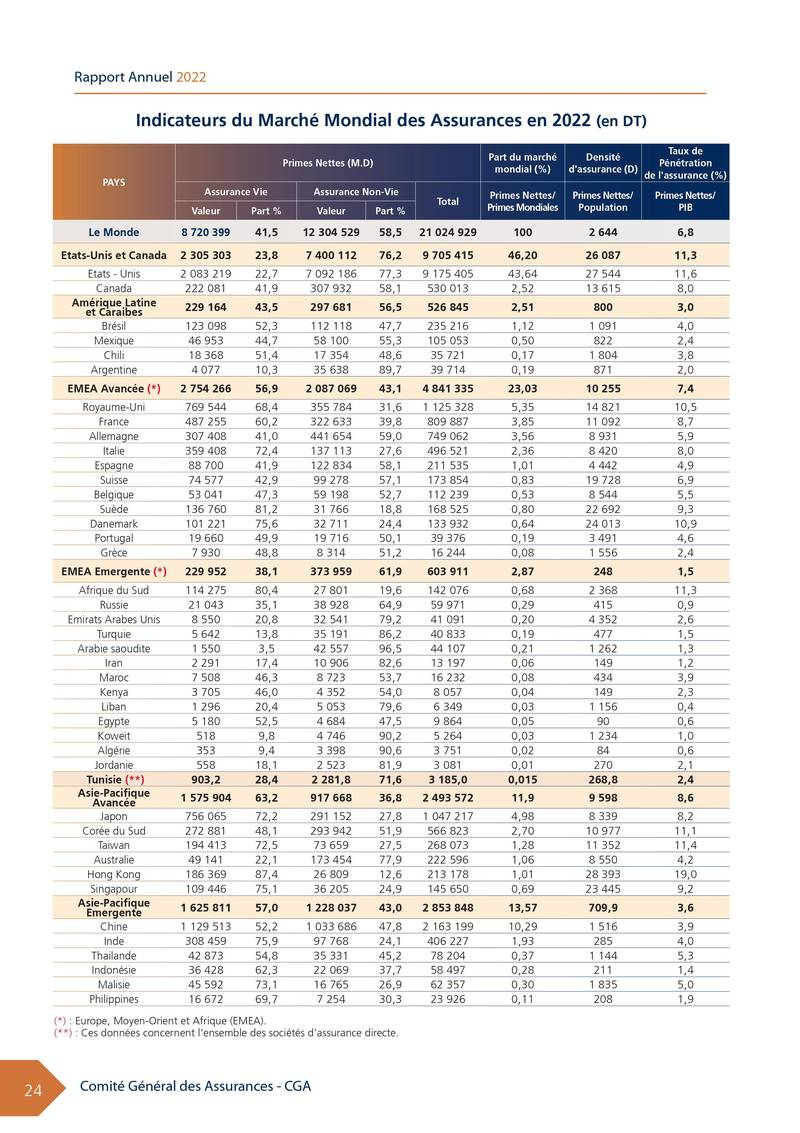

Indicateurs du Marché Mondial des Assurances en 2022 (en DT)
----------------------------------------


,PAYS,Primes Nettes (M-D) Assurance Vie,,Assurance Non-Vie,,Total,Part du marché mondial (\%) Primes Nettes/ Nimes Mondiales,Densité d'assurance (D) Primes Nettes/ Population,Taux de satisfaction d'assurance (\%) Primes Nettes/ PIB
0,,Valeur,Part \%,Valeur,Part \%,,,,
1,Le Monde,8720399,"41,5",12304529,"58,5",21024929,100,2644,"6,8"
2,Etats-Unis et Canada,2305303,"23,8",7400112,"76,2",9705415,"46,20",26087,"11,3"
3,Etats - Unis,2083219,"22,7",7092186,"77,3",9175405,"43,64",27544,"11,6"
4,Canada,222081,"41,9",307932,"58,1",530013,"2,52",13615,"8,0"
5,Amérique Latine et Caraïbes,229164,"43,5",297681,"56,5",526845,"2,51",800,"3,0"
6,Brésil,123098,"52,3",112118,"47,7",235216,"1,12",1091,"4,0"
7,Mexique,46953,"44,7",58100,"55,3",105053,"0,50",822,"2,4"
8,Chili,18368,"51,4",17354,"48,6",35721,"0,17",1804,"3,8"
9,Argentine,4077,"10,3",35638,"89,7",39714,"0,19",871,"2,0"


(*) : Europe, Moyen-Orient et Afrique (EMEA).
(**) : Ces données concernent l'ensemble des sociétés d'assurance directe.


In [7]:
doc_response = parse_doc_with_mistralocr("/kaggle/input/different-tables-images-testing/other_table.jpg")
display_text_with_pdf_or_image_plain(
    doc_response.pages[0].markdown,
    "/kaggle/input/different-tables-images-testing/other_table.jpg"
)

## **Example n°2**


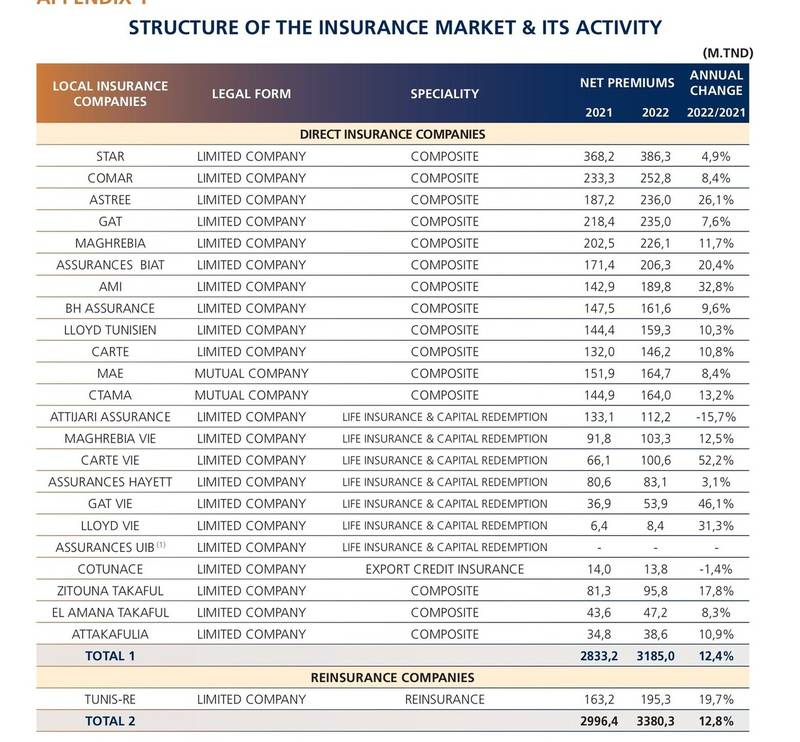

# STRUCTURE OF THE INSURANCE MARKET \& ITS ACTIVITY

(M.TND)
----------------------------------------


,LOCAL INSURANCE COMPANIES,LEGAL FORM,SPECIALITY,NET PREMIUMS 2021,2022,ANNUAL CHANGE 2022/2021
0,DIRECT INSURANCE COMPANIES,,,,,
1,STAR,LIMITED COMPANY,COMPOSITE,"368,2","386,3","4,9\%"
2,COMAR,LIMITED COMPANY,COMPOSITE,"233,3","252,8","8,4\%"
3,ASTREE,LIMITED COMPANY,COMPOSITE,"187,2","236,0","26,1\%"
4,GAT,LIMITED COMPANY,COMPOSITE,"218,4","235,0","7,6\%"
5,MAGHREBIA,LIMITED COMPANY,COMPOSITE,"202,5","226,1","11,7\%"
6,ASSURANCES BIAT,LIMITED COMPANY,COMPOSITE,"171,4","206,3","20,4\%"
7,AMI,LIMITED COMPANY,COMPOSITE,"142,9","189,8","32,8\%"
8,BH ASSURANCE,LIMITED COMPANY,COMPOSITE,"147,5","161,6","9,6\%"
9,LLOYD TUNISIEN,LIMITED COMPANY,COMPOSITE,"144,4","159,3","10,3\%"


In [8]:
doc_response = parse_doc_with_mistralocr("/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-79 (1) (1).jpg")
display_text_with_pdf_or_image_plain(
    doc_response.pages[0].markdown,
    "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-79 (1) (1).jpg"
)

## **Example n°3**


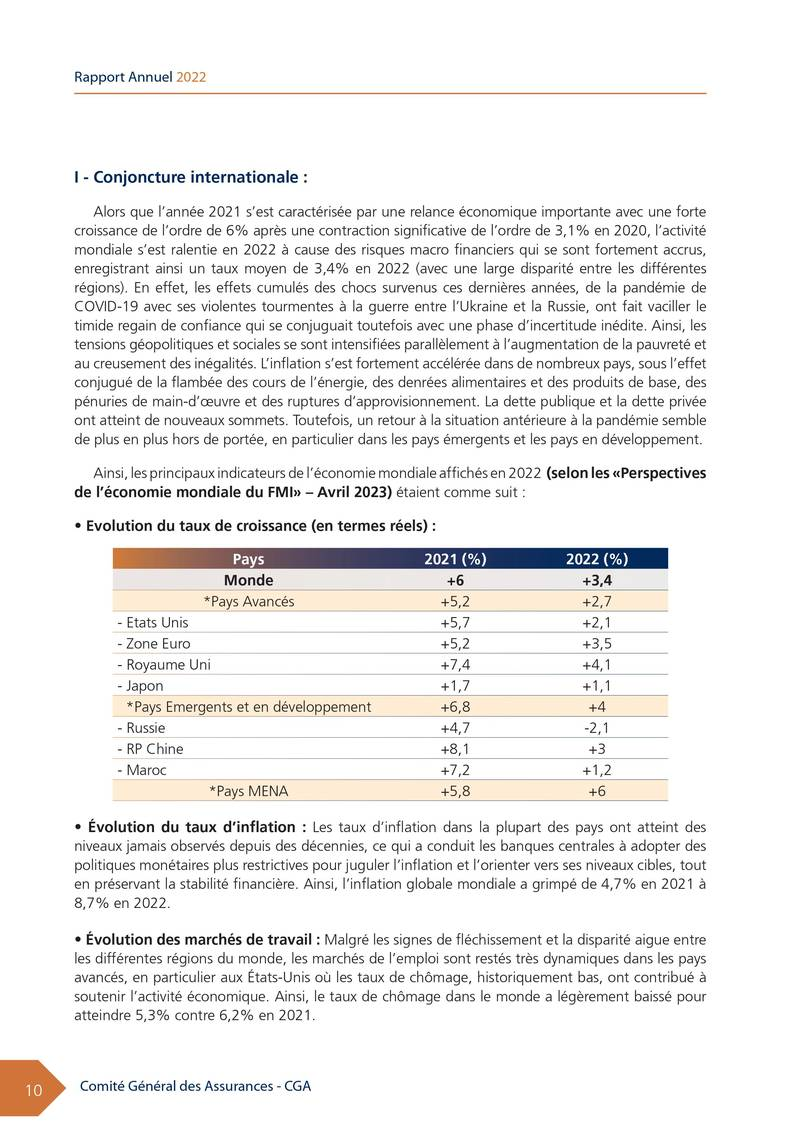

# I - Conjoncture internationale : 

Alors que l'année 2021 s'est caractérisée par une relance économique importante avec une forte croissance de l'ordre de $6 \%$ après une contraction significative de l'ordre de 3,1\% en 2020, I'activité mondiale s'est ralentie en 2022 à cause des risques macro financiers qui se sont fortement accrus, enregistrant ainsi un taux moyen de 3,4\% en 2022 (avec une large disparité entre les différentes régions). En effet, les effets cumulés des chocs survenus ces dernières années, de la pandémie de COVID-19 avec ses violentes tourmentes à la guerre entre l'Ukraine et la Russie, ont fait vaciller le timide regain de confiance qui se conjuguait toutefois avec une phase d'incertitude inédite. Ainsi, les tensions géopolitiques et sociales se sont intensifiées parallèlement à l'augmentation de la pauvreté et au creusement des inégalités. L'inflation s'est fortement accélérée dans de nombreux pays, sous l'effet conjugué de la flambée des cours de l'énergie, des

,Pays Monde,2021 (\%) +6,"2022 (\%) +3,4"
0,*Pays Avancés,"+5,2","+2,7"
1,- Etats Unis,"+5,7","+2,1"
2,- Zone Euro,"+5,2","+3,5"
3,- Royaume Uni,"+7,4","+4,1"
4,- Japon,"+1,7","+1,1"
5,*Pays Emergents et en développement,"+6,8",+4
6,- Russie,"+4,7","-2,1"
7,- RP Chine,"+8,1",+3
8,- Maroc,"+7,2","+1,2"
9,*Pays MENA,"+5,8",+6


- Évolution du taux d'inflation : Les taux d'inflation dans la plupart des pays ont atteint des niveaux jamais observés depuis des décennies, ce qui a conduit les banques centrales à adopter des politiques monétaires plus restrictives pour juguler l'inflation et l'orienter vers ses niveaux cibles, tout en préservant la stabilité financière. Ainsi, l'inflation globale mondiale a grimpé de 4,7\% en 2021 à $8,7 \%$ en 2022.
- Évolution des marchés de travail : Malgré les signes de fléchissement et la disparité aigue entre les différentes régions du monde, les marchés de l'emploi sont restés très dynamiques dans les pays avancés, en particulier aux États-Unis où les taux de chômage, historiquement bas, ont contribué à soutenir l'activité économique. Ainsi, le taux de chômage dans le monde a légèrement baissé pour atteindre 5,3\% contre 6,2\% en 2021.


In [9]:
doc_response = parse_doc_with_mistralocr("/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-10.jpg")
display_text_with_pdf_or_image_plain(
    doc_response.pages[0].markdown,
    "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-10.jpg"
)

## **Example n°4**


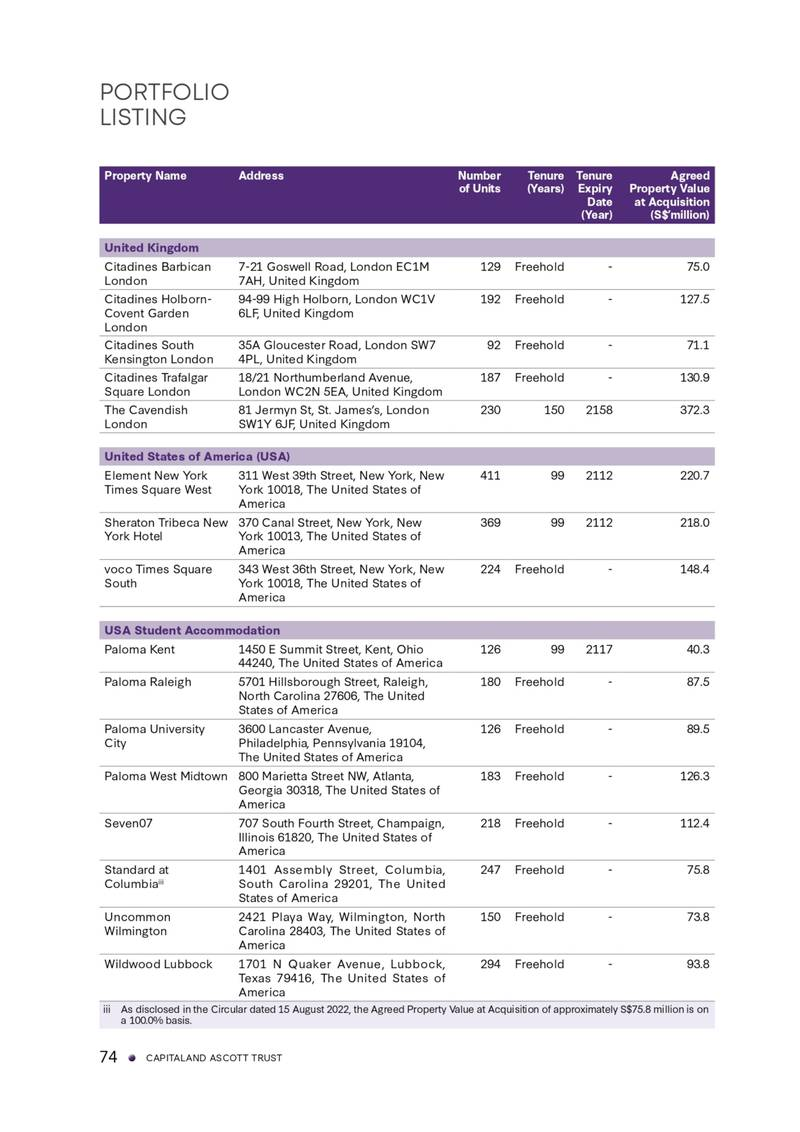

PORTFOLIO LISTING
----------------------------------------


,Property Name United Kingdom,Address,Number of Units,Tenure (Years),Tenure Expiry Date (Year),Agreed Property Value at Acquisition (S\ million)
0,Citadines Barbican London,"7-21 Goswell Road, London EC1M 7AH, United Kin...",129,Freehold,-,75.0
1,Citadines Holborn- Covent Garden London,"94-99 High Holborn, London WC1V 6LF, United Ki...",192,Freehold,-,127.5
2,Citadines South Kensington London,"35A Gloucester Road, London SW7 4PL, United Ki...",92,Freehold,-,71.1
3,Citadines Trafalgar Square London,"18/21 Northumberland Avenue, London WC2N 5EA, ...",187,Freehold,-,130.9
4,The Cavendish London,"81 Jermyn St, St. James's, London SW1Y 6JF, Un...",230,150,2158,372.3
5,United States of America (USA),,,,,
6,Element New York Times Square West,"311 West 39th Street, New York, New York 10018...",411,99,2112,220.7
7,Sheraton Tribeca New York Hotel,"370 Canal Street, New York, New York 10013, Th...",369,99,2112,218.0
8,voco Times Square South,"343 West 36th Street, New York, New York 10018...",224,Freehold,-,148.4
9,USA Student Accommodation,,,,,


iii As disclosed in the Circular dated 15 August 2022, the Agreed Property Value at Acquisition of approximately S\$75.8 million is on a 100.0\% basis.


In [10]:
doc_response = parse_doc_with_mistralocr("/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0076.pdf")
display_text_with_pdf_or_image_plain(
    doc_response.pages[0].markdown,
    "/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0076.pdf"
)

## **Example n°5**


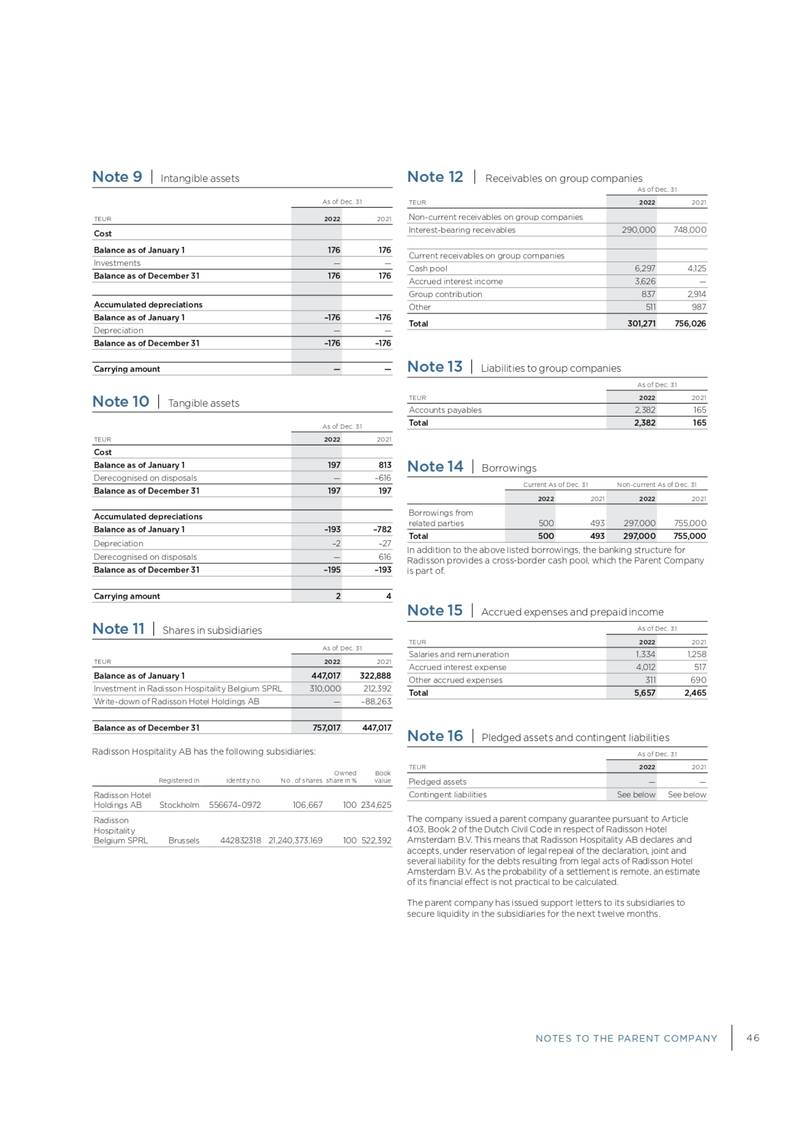

Note 9 | Intangible assets
----------------------------------------


,TELUR,2022
0,Cost,
1,Balance as of January 1,176
2,Investments,—
3,Balance as of December 31,176
4,Accumulated depreciations,
5,Balance as of January 1,-176
6,Depreciation,—
7,Balance as of December 31,-176
8,Carrying amount,—


Note 10 | Tangible assets
----------------------------------------


,TELUR,2022
0,Cost,
1,Balance as of January 1,197
2,Derecognised on disposals,—
3,Balance as of December 31,197
4,Accumulated depreciations,
5,Balance as of January 1,-193
6,Depreciation,—
7,Derecognised on disposals,—
8,Balance as of December 31,-195
9,Carrying amount,2


Note 11 | Shares in subsidiaries
----------------------------------------


,TELUR,2022
0,Balance as of January 1,"447,017"
1,Investment in Radisson Hospitality Belgium SPRL,"310,000"
2,Write-down of Radisson Hotel Holdings AB,—
3,Balance as of December 31,"757,017"


Radisson Hospitality AB has the following subsidiaries:
----------------------------------------


,Registered in,identity no.
0,Radisson Hotel,
1,Holdings AB,Stockholm
2,Radisson,
3,Hospitality,
4,Belgium SPRL,Brussels


Note 12 | Receivables on group companies
----------------------------------------


,TELUR,2022
0,Non-current receivables on group companies,—
1,Interest-bearing receivables,"290,000"
2,Current receivables on group companies,—
3,Cash pool,"6,297"
4,Accrued interest income,"3,626"
5,Group contribution,837
6,Other,511
7,Total,"301,271"


Note 13 | Liabilities to group companies
----------------------------------------


,TELUR,2022
0,Accounts payables,"2,382"
1,Total,"2,382"


Note 14 | Borrowings
----------------------------------------


,Current As of Dec. 31,Non-current As of Dec. 31
0,2022,2021
1,Borrowings from related parties,500
2,500,493
3,500,493


Note 15 | Accrued expenses and prepaid income
----------------------------------------


,TELUR,2022
0,Salaries and remuneration,"1,334"
1,Accrued interest expense,"4,012"
2,Other accrued expenses,311
3,Total,"5,657"


Note 16 | Pledged assets and contingent liabilities
----------------------------------------


,TELUR,2022
0,Pledged assets,—
1,Contingent liabilities,See below


The company issued a parent company guarantee pursuant to Article 403, Book 2 of the Dutch Civil Code in respect of Radisson Hotel Amsterdam B.V. This means that Radisson Hospitality AB declares and accepts, under reservation of legal repeal of the declaration, joint and several liability for the debts resulting from legal acts of Radisson Hotel Amsterdam B.V. As the probability of a settlement is remote, an estimate of its financial effect is not practical to be calculated.

The parent company has issued support letters to its subsidiaries to secure liquidity in the subsidiaries for the next twelve months.


In [11]:
doc_response = parse_doc_with_mistralocr("/kaggle/input/pdf-files-pages/RHG_annual_report_2022_page-0047.pdf")
display_text_with_pdf_or_image_plain(
    doc_response.pages[0].markdown,
    "/kaggle/input/pdf-files-pages/RHG_annual_report_2022_page-0047.pdf"
)

## **Example n°6**


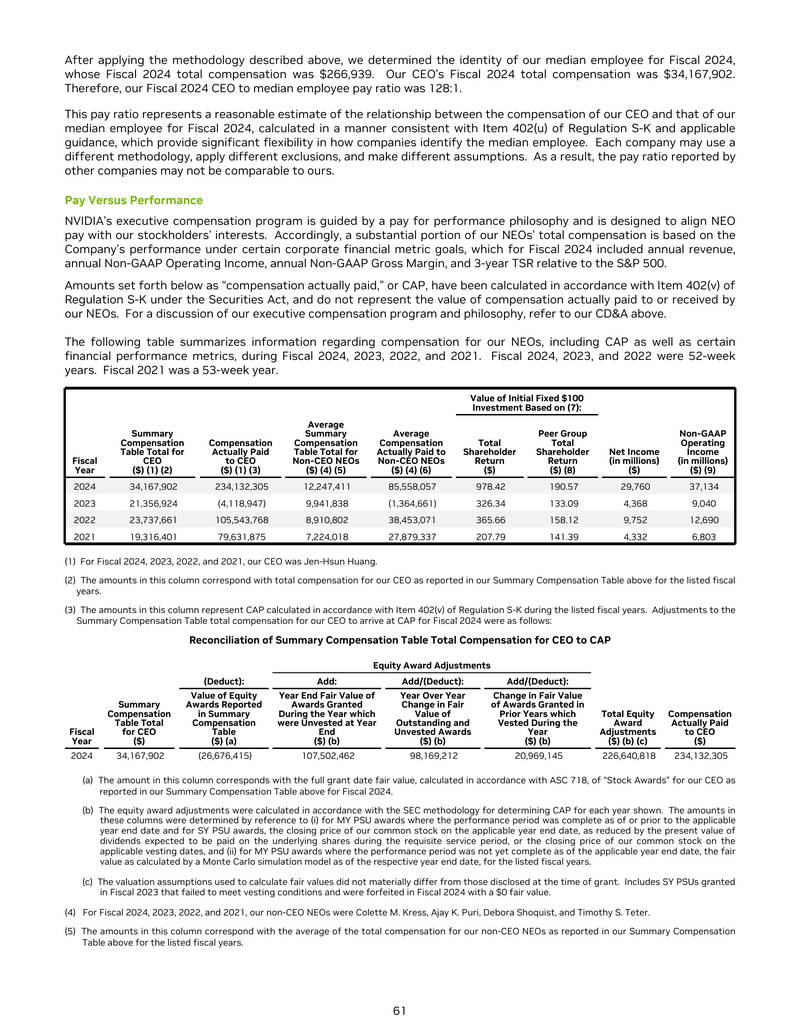

After applying the methodology described above, we determined the identity of our median employee for Fiscal 2024, whose Fiscal 2024 total compensation was $\$ 266,939$. Our CEO's Fiscal 2024 total compensation was $\$ 34,167,902$. Therefore, our Fiscal 2024 CEO to median employee pay ratio was 128:1.

This pay ratio represents a reasonable estimate of the relationship between the compensation of our CEO and that of our median employee for Fiscal 2024, calculated in a manner consistent with Item 402(u) of Regulation S-K and applicable guidance, which provide significant flexibility in how companies identify the median employee. Each company may use a different methodology, apply different exclusions, and make different assumptions. As a result, the pay ratio reported by other companies may not be comparable to ours.

# Pay Versus Performance 

NVIDIA's executive compensation program is guided by a pay for performance philosophy and is designed to align NEO pay with our stockholders' in

,Fiscal Year,Summary Compensation Table Total for CEO (\) (1) (2),Compensation Actually Paid to CEO (\) (1) (3),Average Summary Compensation Table Total for Non-CEO NEOs (\) (4) (5),Average Compensation Actually Paid to Non-CEO NEOs (\) (4) (6),Value of Initial Fixed \ 100 Investment Based on (7): Total Shareholder Return (\),Peer Group Total Shareholder Return (\) (8),Net Income (in millions) (\),Non-GAAP Operating Income (in millions) (\) (9)
0,2024,"34,167,902","234,132,305","12,247,411","85,558,057",978.42,190.57,"29,760","37,134"
1,2023,"21,356,924","(4,118,947)","9,941,838","(1,364,661)",326.34,133.09,"4,368","9,040"
2,2022,"23,737,661","105,543,768","8,910,802","38,453,071",365.66,158.12,"9,752","12,690"
3,2021,"19,316,401","79,631,875","7,224,018","27,879,337",207.79,141.39,"4,332","6,803"


(1) For Fiscal 2024, 2023, 2022, and 2021, our CEO was Jen-Hsun Huang.
(2) The amounts in this column correspond with total compensation for our CEO as reported in our Summary Compensation Table above for the listed fiscal years.
(3) The amounts in this column represent CAP calculated in accordance with Item 402(v) of Regulation S-K during the listed fiscal years. Adjustments to the Summary Compensation Table total compensation for our CEO to arrive at CAP for Fiscal 2024 were as follows:

Reconciliation of Summary Compensation Table Total Compensation for CEO to CAP
----------------------------------------


,Fiscal Year,Summary Compensation Table Total for CEO (\),Equity Award Adjustments (Deduct): Value of Equity Awards Reported in Summary Compensation Table (\) (a),Add: Year End Fair Value of Awards Granted During the Year which were Unvested at Year End (\) (b),Add/(Deduct): Year Over Year Change in Fair Value of Outstanding and Unvested Awards (\) (b),Add/(Deduct): Change in Fair Value of Awards Granted in Prior Years which Vested During the Year (\) (b),,Total Equity Award Adjustments (\) (b) (c),Compensation Actually Paid to CEO (\)
0,2024,"34,167,902","(26,676,415)","107,502,462","98,169,212","20,969,145","226,640,818","234,132,305",


(a) The amount in this column corresponds with the full grant date fair value, calculated in accordance with ASC 718, of "Stock Awards" for our CEO as reported in our Summary Compensation Table above for Fiscal 2024.
(b) The equity award adjustments were calculated in accordance with the SEC methodology for determining CAP for each year shown. The amounts in these columns were determined by reference to (i) for MY PSU awards where the performance period was complete as of or prior to the applicable year end date and for SY PSU awards, the closing price of our common stock on the applicable year end date, as reduced by the present value of dividends expected to be paid on the underlying shares during the requisite service period, or the closing price of our common stock on the applicable vesting dates, and (ii) for MY PSU awards where the performance period was not yet complete as of the applicable year end date, the fair value as calculated by a Monte Carlo simulation model as of the r

In [12]:
doc_response = parse_doc_with_mistralocr("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-6.pdf")
display_text_with_pdf_or_image_plain(
    doc_response.pages[0].markdown,
    "/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-6.pdf"
)

## **Example n°7**


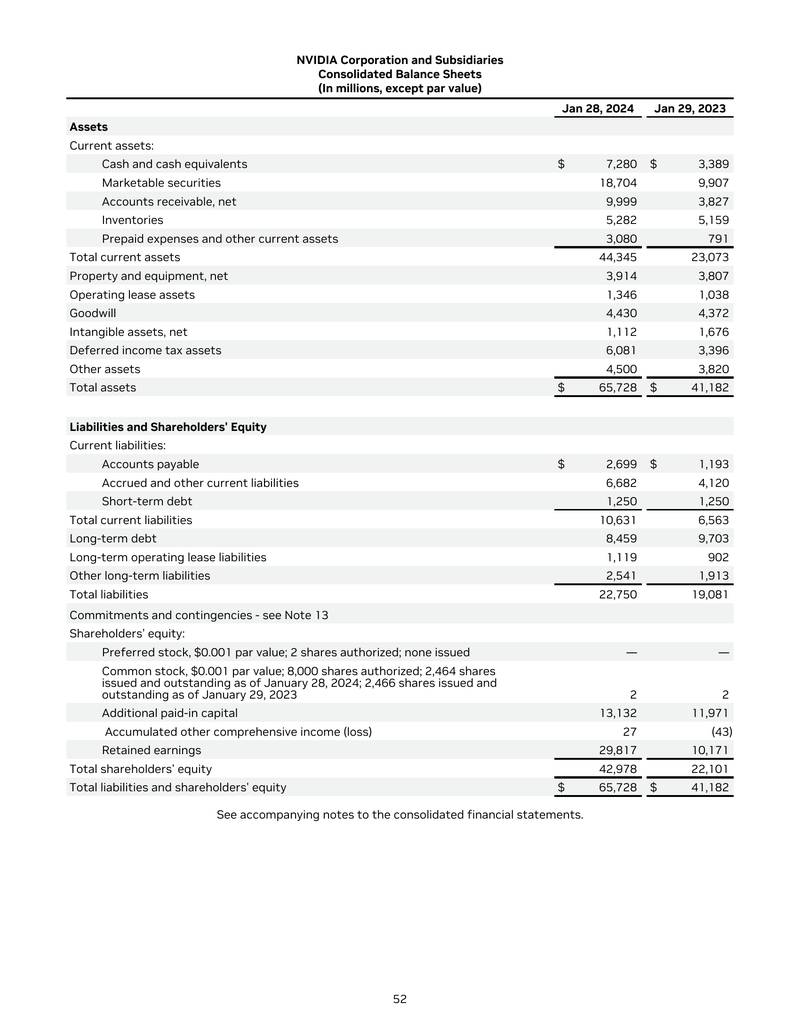

,Assets,"Jan 28, 2024","Jan 29, 2023"
0,Current assets:,,
1,Cash and cash equivalents,"7,280","3,389"
2,Marketable securities,"18,704","9,907"
3,"Accounts receivable, net","9,999","3,827"
4,Inventories,"5,282","5,159"
5,Prepaid expenses and other current assets,"3,080",791
6,Total current assets,"44,345","23,073"
7,"Property and equipment, net","3,914","3,807"
8,Operating lease assets,"1,346","1,038"
9,Goodwill,"4,430","4,372"


In [13]:
doc_response = parse_doc_with_mistralocr("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-14.pdf")
display_text_with_pdf_or_image_plain(
    doc_response.pages[0].markdown,
    "/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-14.pdf"
)

## **Example n°8**


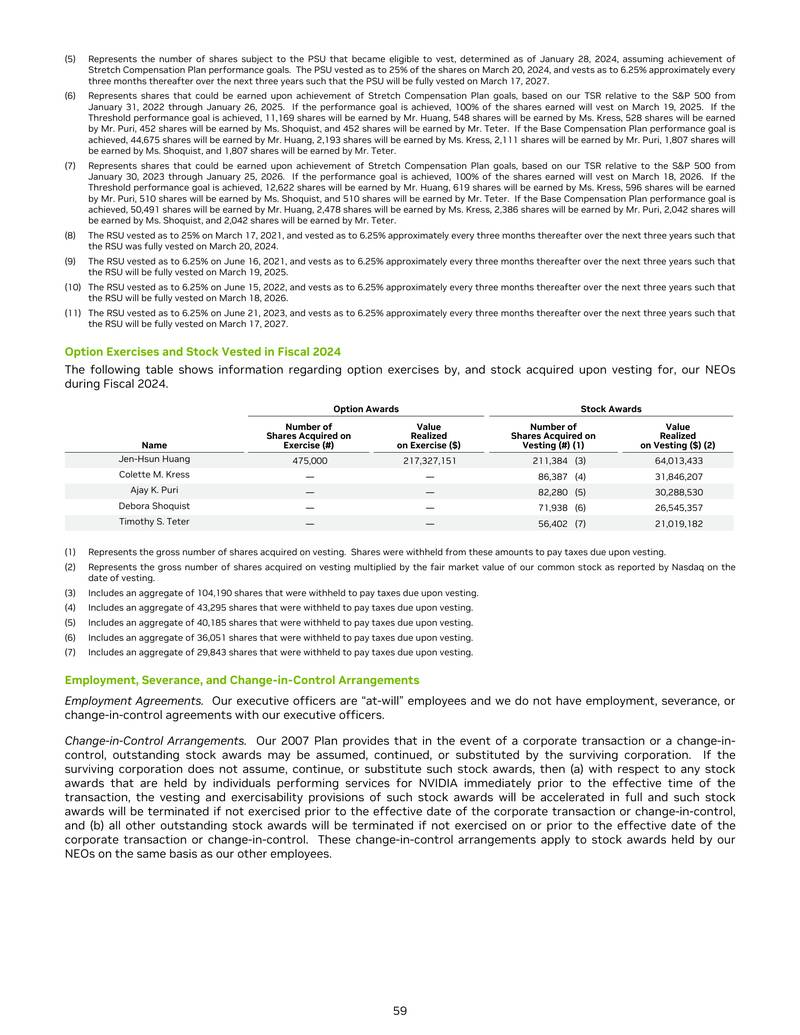

(5) Represents the number of shares subject to the PSU that became eligible to vest, determined as of January 28, 2024, assuming achievement of Stretch Compensation Plan performance goals. The PSU vested as to 25\% of the shares on March 20, 2024, and vests as to 6.25\% approximately every three months thereafter over the next three years such that the PSU will be fully vested on March 17, 2027.
(6) Represents shares that could be earned upon achievement of Stretch Compensation Plan goals, based on our TSR relative to the S\&P 500 from January 31, 2022 through January 26, 2025. If the performance goal is achieved, 100\% of the shares earned will vest on March 19, 2025. If the Threshold performance goal is achieved, 11,169 shares will be earned by Mr. Huang, 548 shares will be earned by Ms. Kress, 528 shares will be earned by Mr. Puri, 452 shares will be earned by Ms. Shoquist, and 452 shares will be earned by Mr. Teter. If the Base Compensation Plan performance goal is achieved, 44,675

,Name,Option Awards Number of Shares Acquired on Exercise (\),Value Realized on Exercise (\),Stock Awards Number of Shares Acquired on Vesting (\) (1),Value Realized on Vesting (\) (2)
0,Jen-Hsun Huang,"475,000","217,327,151","211,384 (3)","64,013,433"
1,Colette M. Kress,-,-,"86,387 (4)","31,846,207"
2,Ajay K. Puri,-,-,"82,280 (5)","30,288,530"
3,Debora Shoquist,-,-,"71,938 (6)","26,545,357"
4,Timothy S. Teter,-,-,"56,402 (7)","21,019,182"


(1) Represents the gross number of shares acquired on vesting. Shares were withheld from these amounts to pay taxes due upon vesting.
(2) Represents the gross number of shares acquired on vesting multiplied by the fair market value of our common stock as reported by Nasdaq on the date of vesting.
(3) Includes an aggregate of 104,190 shares that were withheld to pay taxes due upon vesting.
(4) Includes an aggregate of 43,295 shares that were withheld to pay taxes due upon vesting.
(5) Includes an aggregate of 40,185 shares that were withheld to pay taxes due upon vesting.
(6) Includes an aggregate of 36,051 shares that were withheld to pay taxes due upon vesting.
(7) Includes an aggregate of 29,843 shares that were withheld to pay taxes due upon vesting.

## Employment, Severance, and Change-in-Control Arrangements

Employment Agreements. Our executive officers are "at-will" employees and we do not have employment, severance, or change-in-control agreements with our executive officers.


In [14]:
doc_response = parse_doc_with_mistralocr("/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-4.pdf")
display_text_with_pdf_or_image_plain(
    doc_response.pages[0].markdown,
    "/kaggle/input/nvidia-annual-report/NVIDIA_Report_Removed_Pages-1-16-4.pdf"
)

## **Example n°9**


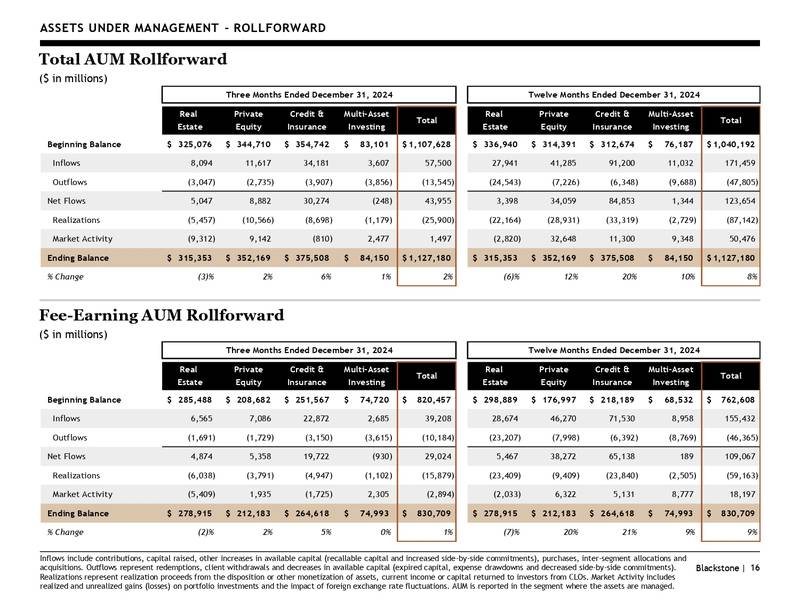

# ASSETS UNDER MANAGEMENT - ROLLFORWARD

## Total AUM Rollforward

( $\$$ in millions)
----------------------------------------
[Could not parse table]
|   | Three Months Ended December 31, 2024 |  |  |  |  | Twelve Months Ended December 31, 2024 |  |  |  |   |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
|   | 
Real
Estate | Private
Equity | Credit \& Insurance | Multi-Asset Investing | Total | Real
Estate | Private
Equity | Credit \& Insurance | Multi-Asset Investing | Total  |
|  Beginning Balance | \$ 325,076 | \$ 344,710 | \$ 354,742 | \$ 83,101 | \$ 1,107,628 | \$ 336,940 | \$ 314,391 | \$ 312,674 | \$ 76,187 | \$ 1,040,192  |
|  Inflows | 8,094 | 11,617 | 34,181 | 3,607 | 57,500 | 27,941 | 41,285 | 91,200 | 11,032 | 171,459  |
|  Outflows | $(3,047)$ | $(2,735)$ | $(3,907)$ | $(3,856)$ | $(13,545)$ | $(24,543)$ | $(7,226)$ | $(6,348)$ | $(9,688)$ | $(47,805)$  |
|  Net Flows | 5,047 | 8,882 | 30,274 | (248) | 43,955 | 3,398 | 34,059 | 84,853 | 1,344 | 123,

In [17]:
doc_response = parse_doc_with_mistralocr("/kaggle/input/pdf-files-pages/Blackstone4Q24EarningsPressRelease_page-0020.jpg")
display_text_with_pdf_or_image_plain(
    doc_response.pages[0].markdown,
    "/kaggle/input/pdf-files-pages/Blackstone4Q24EarningsPressRelease_page-0020.jpg"
)